In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

import torch

import constant
import tools
import myplot
import features
from models import MLP_Regression, train_model, timeseries_kfold_validation_training

# Load Files

In [2]:
path = "PH_SC_1/"
settlement = pd.read_parquet(constant.settlement_train_path)
dtype = {"GSRN":str,"Parent_GSRN":str,"Turbine_type":str,"BBR_municipal":str,"Placement":str,"grid":str}
windmill = pd.read_csv(constant.windmill_PH_SC_path, dtype=dtype)

wu10 = pd.read_parquet(constant.wu10_path)
wv10 = pd.read_parquet(constant.wv10_path)
wu100 = pd.read_parquet(constant.wu100_path)
wv100 = pd.read_parquet(constant.wv100_path)

tmp2 = pd.read_parquet(constant.tmp2_path)
tmp100 = pd.read_parquet(constant.tmp100_path)

In [3]:
len(windmill)

2

In [4]:
df = pd.merge(windmill, settlement, on="GSRN")

# Feature Extraction

In [5]:
features.fun_register(wu10, wv10, wu100, wv100, tmp2, tmp100)

In [6]:
df = features.parallelize_extract(df)

parallelize_extract time:  150.42851376533508


In [7]:
df,ply_models_rn,_ = features.extract_quantiles(df, "hws_uv_rn")
df,ply_models_wsr,_ = features.extract_quantiles(df, "hws_uv_wsr")

In [25]:
cols_filter = ["grid", "month", "hour", "GSRN", "Turbine_type", "Placement", "Parent_GSRN", "BBR_municipal", "TIME_CET", "predicted_ahead", 'UTM_x', 'UTM_y', 'VAERDI', 'max_VAERDI', 'In_service']

In [26]:
feat = [x for x in df.columns if x not in cols_filter]
df = tools.normalize_features(df, feat)

In [27]:
df["TIME_CET"] = pd.to_datetime(df["TIME_CET"])

In [28]:
date_s = pd.to_datetime("2019-03-01")
df_train = df[df["TIME_CET"] < date_s].sort_values(["TIME_CET", "GSRN"]).reset_index(drop=True)
df_evl = df[df["TIME_CET"] >= date_s].sort_values(["TIME_CET", "GSRN").reset_index(drop=True)

In [ ]:
len(df_train)

In [ ]:
df_train.to_csv(constant.PH_SC_TRAIN_path, index=False)
df_evl.to_csv(constant.PH_SC_EVL_path, index=False)

# Neural Network Train

In [ ]:
df_train = pd.read_csv(constant.SL_SC_TRAIN_path)

In [29]:
target = ["VAERDI"]
n_groups=5
lr=0.001
num_epochs=20
hidden_size = 1000
output_size = 1

## Original Features


In [88]:
cols = ['Capacity_kw', 'Navhub_height', 'Rotor_diameter',
'wu10', 'wv10', 'wu100', 'wv100', 'tmp2', 'tmp100',
'm1', 'm2', 'm3', 'm4', 'm5', 'm6', 'm7', 'm8', 'm9', 'm10', 'm11', 'm12',
'h0', 'h1', 'h2', 'h3', 'h4', 'h5', 'h6', 'h7', 'h8', 'h9', 'h10', 'h11', 'h12', 'h13', 'h14', 'h15', 'h16', 'h17', 'h18', 'h19', 'h20', 'h21', 'h22', 'h23']

In [89]:
model_original = MLP_Regression(
  input_size=45,
  hidden_size=hidden_size
)
model_original, train_hist_original, test_hist_original = timeseries_kfold_validation_training(df=df_train, features=cols, target=target, n_groups=n_groups, model=model_original, lr=lr, num_epochs=num_epochs, save_name=path+"original_model.pth")

Epoch 0 train loss: 0.05119871348142624 test loss: 0.052559204399585724
Epoch 10 train loss: 0.031626757234334946 test loss: 0.032753437757492065
Epoch 19 train loss: 0.029691968113183975 test loss: 0.034939300268888474
Epoch 0 train loss: 0.03222721442580223 test loss: 0.024947011843323708
Epoch 10 train loss: 0.02931191585958004 test loss: 0.018508754670619965
Epoch 19 train loss: 0.027477435767650604 test loss: 0.019098779186606407
Epoch 0 train loss: 0.024587448686361313 test loss: 0.022254658862948418
Epoch 10 train loss: 0.02289567142724991 test loss: 0.02095908112823963
Epoch 19 train loss: 0.021341519430279732 test loss: 0.019702402874827385
Epoch 0 train loss: 0.02064872905611992 test loss: 0.030171291902661324
Epoch 10 train loss: 0.01957254856824875 test loss: 0.02960890531539917
Epoch 19 train loss: 0.018260449171066284 test loss: 0.02915828675031662


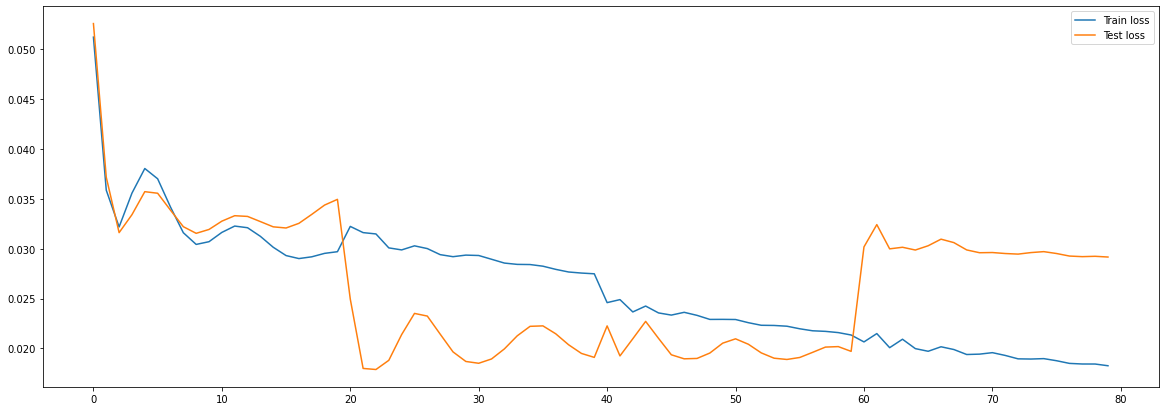

In [90]:
myplot.model_loss({"Train loss":train_hist_original, "Test loss": test_hist_original}, save_name=path+"original_loss.png")

## Windshear Features

In [70]:
cols = ['Capacity_kw','Navhub_height','Rotor_diameter',
'hws_u_wsr','hws_v_wsr','hws_uv_wsr','hws_uv_wsr^2','hws_uv_wsr^3','htmp_exp',
'hws_uv_wsr_q0.1','hws_uv_wsr_q0.3','hws_uv_wsr_q0.5','hws_uv_wsr_q0.7','hws_uv_wsr_q0.9',
'm1', 'm2', 'm3', 'm4', 'm5', 'm6', 'm7', 'm8', 'm9', 'm10', 'm11', 'm12',
'h0', 'h1', 'h2', 'h3', 'h4', 'h5', 'h6', 'h7', 'h8', 'h9', 'h10', 'h11', 'h12', 'h13', 'h14', 'h15', 'h16', 'h17', 'h18', 'h19', 'h20', 'h21', 'h22', 'h23']

In [36]:
model_wsr = MLP_Regression(
  input_size=50,
  hidden_size=hidden_size
)
model_wsr, train_hist_wsr, test_hist_wsr = timeseries_kfold_validation_training(df=df_train, features=cols, target=target, n_groups=n_groups, model=model_wsr, lr=lr, num_epochs=num_epochs, save_name=path+"wsr_model.pth")

Epoch 0 train loss: 0.0586744099855423 test loss: 0.053988512605428696
Epoch 10 train loss: 0.015707792714238167 test loss: 0.02044740505516529
Epoch 19 train loss: 0.016293661668896675 test loss: 0.02082374133169651
Epoch 0 train loss: 0.018840044736862183 test loss: 0.012448415160179138
Epoch 10 train loss: 0.016690000891685486 test loss: 0.011530966497957706
Epoch 19 train loss: 0.015946371480822563 test loss: 0.010992569848895073
Epoch 0 train loss: 0.014301656745374203 test loss: 0.010154406540095806
Epoch 10 train loss: 0.014616877771914005 test loss: 0.010869644582271576
Epoch 19 train loss: 0.013974244706332684 test loss: 0.010414010845124722
Epoch 0 train loss: 0.013106068596243858 test loss: 0.020481973886489868
Epoch 10 train loss: 0.012598223052918911 test loss: 0.017470583319664
Epoch 19 train loss: 0.01230696588754654 test loss: 0.017436444759368896


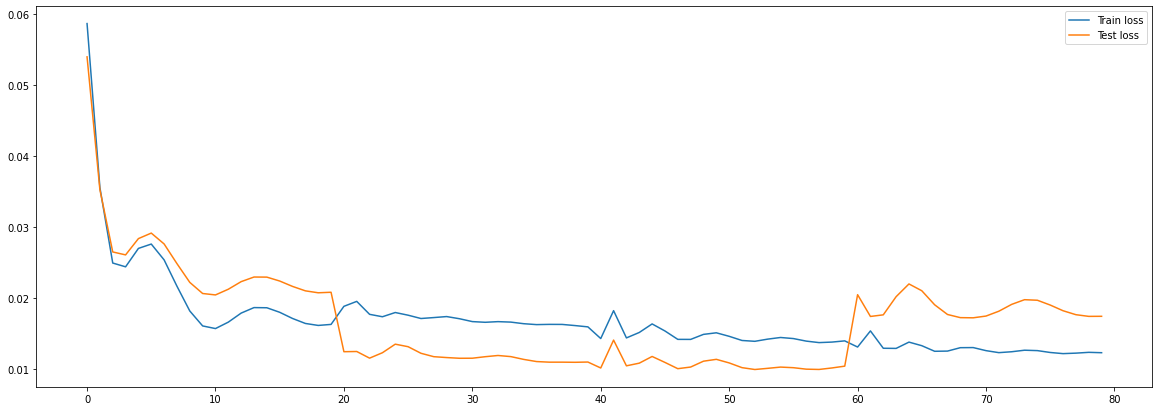

In [37]:
myplot.model_loss({"Train loss":train_hist_wsr, "Test loss": test_hist_wsr}, save_name=path+"wsr_loss.png")

## Geo Features

In [73]:
cols = ['Capacity_kw', 'Navhub_height', 'Rotor_diameter',
'Slope', 'Aspect', 
'hws_u_rn','hws_v_rn','hws_uv_rn','hws_uv_rn^2','hws_uv_rn^3','htmp_exp', 
'hws_uv_rn_q0.1','hws_uv_rn_q0.3','hws_uv_rn_q0.5','hws_uv_rn_q0.7','hws_uv_rn_q0.9',
'm1', 'm2', 'm3', 'm4', 'm5', 'm6', 'm7', 'm8', 'm9', 'm10', 'm11', 'm12',
'h0', 'h1', 'h2', 'h3', 'h4', 'h5', 'h6', 'h7', 'h8', 'h9', 'h10', 'h11', 'h12', 'h13', 'h14', 'h15', 'h16', 'h17', 'h18', 'h19', 'h20', 'h21', 'h22', 'h23']

In [42]:
model_geo = MLP_Regression(
  input_size=52,
  hidden_size=hidden_size
)
model_geo, train_hist_geo, test_hist_geo = timeseries_kfold_validation_training(df=df_train, features=cols, target=target, n_groups=n_groups, model=model_geo, lr=lr, num_epochs=num_epochs, save_name=path+"geo_model.pth")

Epoch 0 train loss: 0.06839196383953094 test loss: 0.060654472559690475
Epoch 10 train loss: 0.010857134126126766 test loss: 0.015230228193104267
Epoch 19 train loss: 0.009203186258673668 test loss: 0.011750718578696251
Epoch 0 train loss: 0.011065526865422726 test loss: 0.007785002700984478
Epoch 10 train loss: 0.009317679330706596 test loss: 0.006118317134678364
Epoch 19 train loss: 0.008729245513677597 test loss: 0.005891710985451937
Epoch 0 train loss: 0.007686780299991369 test loss: 0.0053636315278708935
Epoch 10 train loss: 0.007672169711440802 test loss: 0.005292908754199743
Epoch 19 train loss: 0.007254453841596842 test loss: 0.005293745081871748
Epoch 0 train loss: 0.006787607911974192 test loss: 0.008311398327350616
Epoch 10 train loss: 0.0073336889035999775 test loss: 0.007829553447663784
Epoch 19 train loss: 0.006971711292862892 test loss: 0.007855131290853024


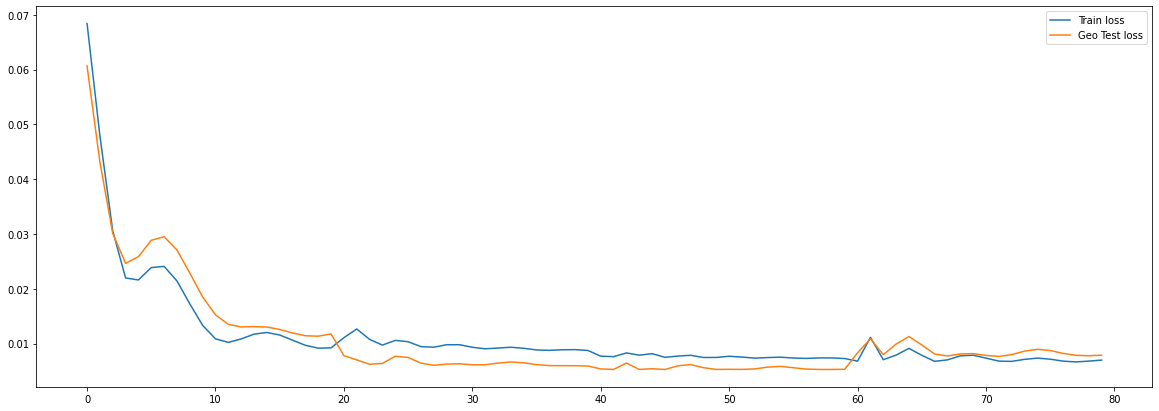

In [43]:
myplot.model_loss({"Train loss":train_hist_geo, "Geo Test loss": test_hist_geo}, save_name=path+"geo_loss.png")

## Semigeo Features

In [76]:
cols = ['Capacity_kw','Navhub_height', 'Rotor_diameter',
'Slope', 'Aspect', 'Roughness',
'hws_u_wsr','hws_v_wsr','hws_uv_wsr','hws_uv_wsr^2','hws_uv_wsr^3','htmp_exp', 
'hws_uv_wsr_q0.1','hws_uv_wsr_q0.3','hws_uv_wsr_q0.5','hws_uv_wsr_q0.7','hws_uv_wsr_q0.9',
'm1', 'm2', 'm3', 'm4', 'm5', 'm6', 'm7', 'm8', 'm9', 'm10', 'm11', 'm12',
'h0', 'h1', 'h2', 'h3', 'h4', 'h5', 'h6', 'h7', 'h8', 'h9', 'h10', 'h11', 'h12', 'h13', 'h14', 'h15', 'h16', 'h17', 'h18', 'h19', 'h20', 'h21', 'h22', 'h23']

In [48]:
model_semigeo = MLP_Regression(
  input_size=53,
  hidden_size=1000
)
model_semigeo, train_hist_semigeo, test_hist_semigeo = timeseries_kfold_validation_training(df=df_train, features=cols, target=target, n_groups=n_groups, model=model_semigeo, lr=lr, num_epochs=num_epochs, save_name=path+"semigeo_model.pth")

Epoch 0 train loss: 0.050456833094358444 test loss: 0.047054968774318695
Epoch 10 train loss: 0.016664044931530952 test loss: 0.021893693134188652
Epoch 19 train loss: 0.017007173970341682 test loss: 0.0220466461032629
Epoch 0 train loss: 0.019323017448186874 test loss: 0.01990957371890545
Epoch 10 train loss: 0.016955355182290077 test loss: 0.015903843566775322
Epoch 19 train loss: 0.016093876212835312 test loss: 0.014978533610701561
Epoch 0 train loss: 0.015937605872750282 test loss: 0.013120480813086033
Epoch 10 train loss: 0.014376016333699226 test loss: 0.00954926572740078
Epoch 19 train loss: 0.013853117823600769 test loss: 0.009629896841943264
Epoch 0 train loss: 0.012709365226328373 test loss: 0.018162820488214493
Epoch 10 train loss: 0.012220429256558418 test loss: 0.017682915553450584
Epoch 19 train loss: 0.012013678438961506 test loss: 0.01710832305252552


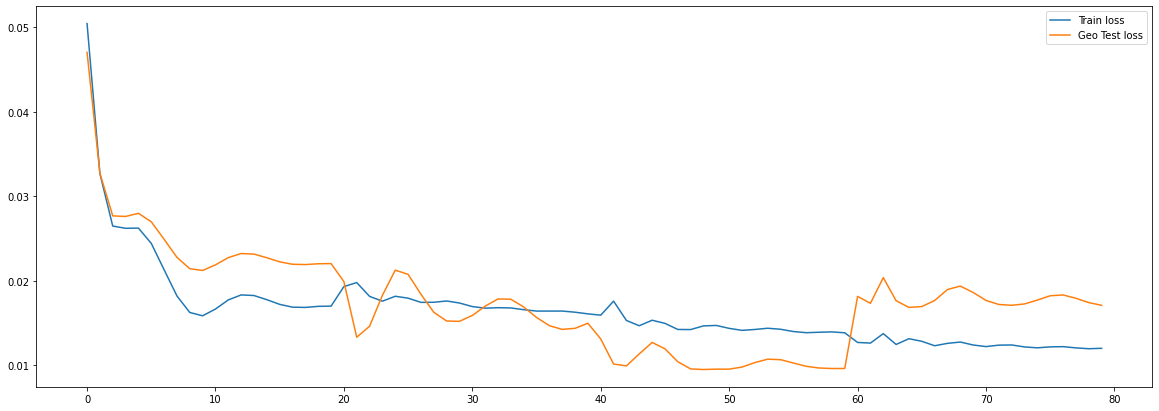

In [49]:
myplot.model_loss({"Train loss":train_hist_semigeo, "Geo Test loss": test_hist_semigeo}, save_name=path+"semigeo_loss.png")